In [13]:
!jupyter-nbconvert --to python --template python_clean Plugin.ipynb

[NbConvertApp] Converting notebook Plugin.ipynb to python
[NbConvertApp] Writing 5900 bytes to Plugin.py


In [1]:
import logging
import hashlib
import time
from epdlib import Layout

In [8]:
logger = logging.getLogger(__name__)

In [9]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
        @strict_enforce(type1, type2, (type3, type4))
        def foo(val1, val2, val3):
            ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [10]:
class SelfDummy:
    '''dummy class for testing plugins'''
    def __init__(self):
        self.layout = {}
        self.max_priority = 1
        self.min_display_time = 20
        self.refresh_rate = 2

In [4]:
class Plugin:
    def __init__(self, resolution, name=None, layout={}, 
                 update_function=None, max_priority=-1,
                 refresh_rate=60, min_display_time=30, config={},
                 cache=None,
                 **kwargs):
        self.name = name
        if resolution:
            self.resolution = resolution
        
        self.layout = layout
        
        if update_function:
            self._add_update_function(update_function)
        else:
#             self.update_function = print('no update function set')
            pass
        
        self.max_priority = max_priority
        
        self.refresh_rate = refresh_rate
        self.min_display_time = min_display_time
        
        self.config = config

        self.cache = cache
        
        self._last_ask = 0
        self.hash = self._generate_hash()
        self.data = {}
        self.image = None
        self.priority = -1
    
    @property
    def name(self):
        '''name of plugin
        name(`str`)'''
        return self._name
    
    @name.setter
    def name(self, name):
        self._name = str(name)
        
    @property
    def resolution(self):
        return self._resolution
        
    @resolution.setter
    @strict_enforce((list, tuple))
    def resolution(self, resolution):
        self._resolution = resolution    
    
    @property
    def layout(self):
        return self.layout_obj.layout
    
    @layout.setter
    @strict_enforce(dict)
    def layout(self, layout):
        self.layout_obj = Layout(resolution=self.resolution, layout=layout)
        
    
    @property
    def cache(self):
        return self._cache
    
    @cache.setter
    def cache(self, cache):
        if cache:
            self._cache = cache
        else:
            self._cache = None
    
    @property
    def last_ask(self):
        '''Records monotonic time of last time an update function was called 
            This is used by the self._is_ready() function to throttle update requests'''
        return self._last_ask
    
    @last_ask.setter
    def last_ask(self, last_ask):
        self._last_ask = last_ask
        
    
    def _add_update_function(self, function):
        self.update_function = function.__get__(self)
        
    def _generate_hash(self):
        my_hash = hashlib.sha1()
        my_hash.update(str(time.time()).encode('utf-8')+str(self.name).encode('utf-8'))
        return my_hash.hexdigest()[:10]        
    
    def _is_ready(self):
        '''simple throttle of update requests
            Checks time between current request (monotonic) and self._last_ask and compares to 
            self.refresh_rate
        
        Returns:
            `bool`: True if cooldown period has expired, false otherwise'''
        if time.monotonic() - self._last_ask > self.refresh_rate:
            self._last_ask = time.monotonic()
            return True
        else:
            logging.debug(f'throttling in effect -- wait for {self.refresh_rate - (time.monotonic() - self._last_ask)} seconds before requesting update')
            return False
        
    def update(self):
        if self._is_ready():
            is_updated, data, priority = self.update_function()
            if data != self.data:
                self.data = data
                self.layout_obj.update_contents(data)
                self.image = self.layout_obj.concat()
                self.hash = self._generate_hash()
            # always update the priority    
            self.priority = priority
        else:
            pass
        
            
        return self.hash
    

In [5]:
def main():
    from random import randint
    from IPython.display import display
    from time import sleep
    bogus_layout = {
        'number': {
            'image': None,
            'max_lines': 1,
            'width': 1,
            'height': 1,
            'abs_coordinates': (0, 0),
            'rand': True,
            'font': '../fonts/Dosis/Dosis-VariableFontwght.ttf',
        },
    }

    # update_function that is added to the plugin as the method self.update_function
    def bogus_plugin(self):
        data = {'number': str(randint(99,9999))}
        priority = self.max_priority
        is_updated = True

        return (is_updated, data, priority) 


    p = Plugin(resolution=(300, 210), 
               refresh_rate=3, 
               max_priority=1, 
               update_function=bogus_plugin, 
               layout=bogus_layout)
    logger.root.setLevel('DEBUG')
    print('this demo is best run from inside jupyter notebook')
    for i in range(100):
        print('trying to update plugin')
        p.update()
        print('displaying image')
        display(p.image)
        print('sleep for 1 second')
        sleep(1)

INFO:root:updating blocks
DEBUG:root:updating block: number
DEBUG:root:formatting string: 8717
DEBUG:root:formatted list:
 ['8717']
DEBUG:root:creating blank image area: (300, 210) with inverse: False
DEBUG:root:line size: 197, 130
DEBUG:root:max x dim so far: 197
DEBUG:root:dimensions of text portion of image: (197, 130)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 197, 130
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 11, 3
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **number** image at: (0, 0)


this demo is best run from inside jupyter notebook
trying to update plugin
displaying image


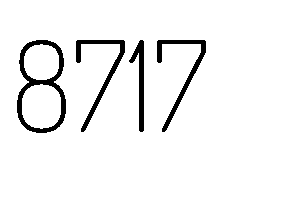

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.8696971839526668 seconds before requesting update


trying to update plugin
displaying image


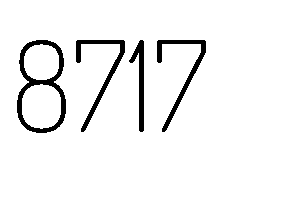

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 0.8501595669658855 seconds before requesting update


trying to update plugin
displaying image


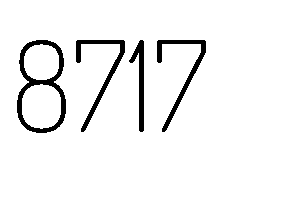

sleep for 1 second


INFO:root:updating blocks
DEBUG:root:updating block: number
DEBUG:root:formatting string: 1871
DEBUG:root:formatted list:
 ['1871']
DEBUG:root:creating blank image area: (300, 210) with inverse: False
DEBUG:root:line size: 168, 130
DEBUG:root:max x dim so far: 168
DEBUG:root:dimensions of text portion of image: (168, 130)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 168, 130
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 83, 7
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **number** image at: (0, 0)


trying to update plugin
displaying image


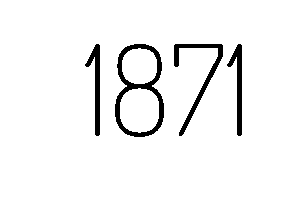

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.9212088589556515 seconds before requesting update


trying to update plugin
displaying image


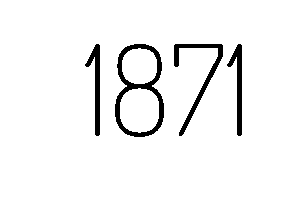

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 0.9011897660093382 seconds before requesting update


trying to update plugin
displaying image


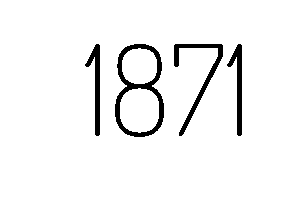

sleep for 1 second


KeyboardInterrupt: 

In [6]:
if __name__ == '__main__':
    main()